In [2]:
import utils
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import EarlyStopping

In [3]:
EPOCHS = 1200
BATCH_SIZE = 32
trading_days = 20
model_type = "SIMPLERNN"

In [4]:
raw_df = utils.download()
df, x = utils.process(df=raw_df, trading_days=trading_days)
utils.test(x=x)
x, y = utils.convert2matrix(data_arr=x, look_back=20)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
X_train = np.expand_dims(X_train, 2)
x_test = np.expand_dims(X_test, 2)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)

ADF Statistic: -6.457758
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
(6533, 20, 1) (6533,) (1634, 20, 1) (1634,)


In [4]:
model = Sequential()
# Input layer
model.add(SimpleRNN(32))
model.add(Dense(units = 1))
model.compile(optimizer="adam",loss="mse",metrics=["mse"])

In [1]:
early_stop = EarlyStopping(monitor="val_loss", patience=100)
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, y_test),
    validation_split=0.2,
    verbose=1,
    shuffle=False,
    callbacks=[early_stop],
)
mse = history.history["mse"]
val_mse = history.history["val_mse"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]


NameError: name 'EarlyStopping' is not defined

In [ ]:
epochs = range(len(mse))
n_epochs = len(mse)
pred = model.predict(x_test)
prediction = utils.compute_prediction_frame(y_labels=y_test,predicted=pred)

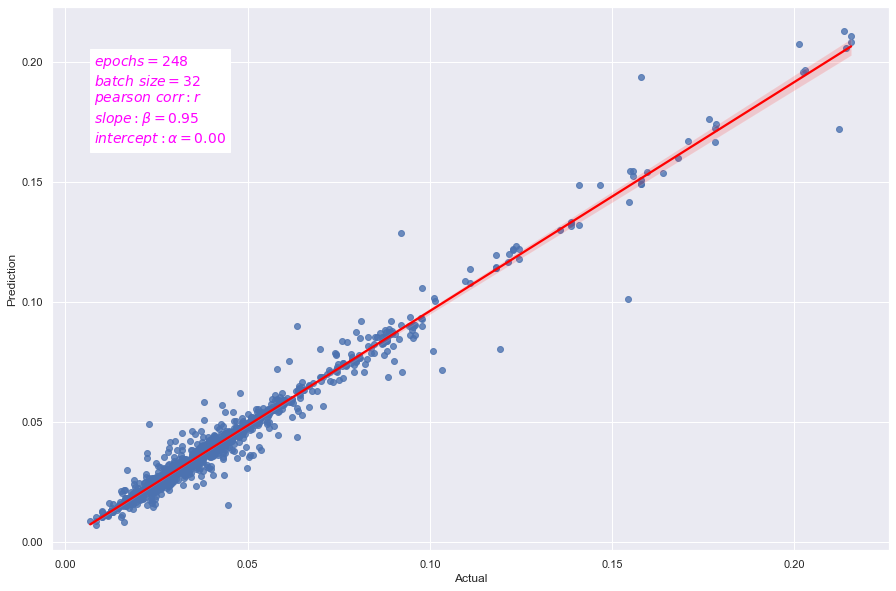

Beta of  Prediction  = 0.9534
Alpha of  Prediction  = 0.0008


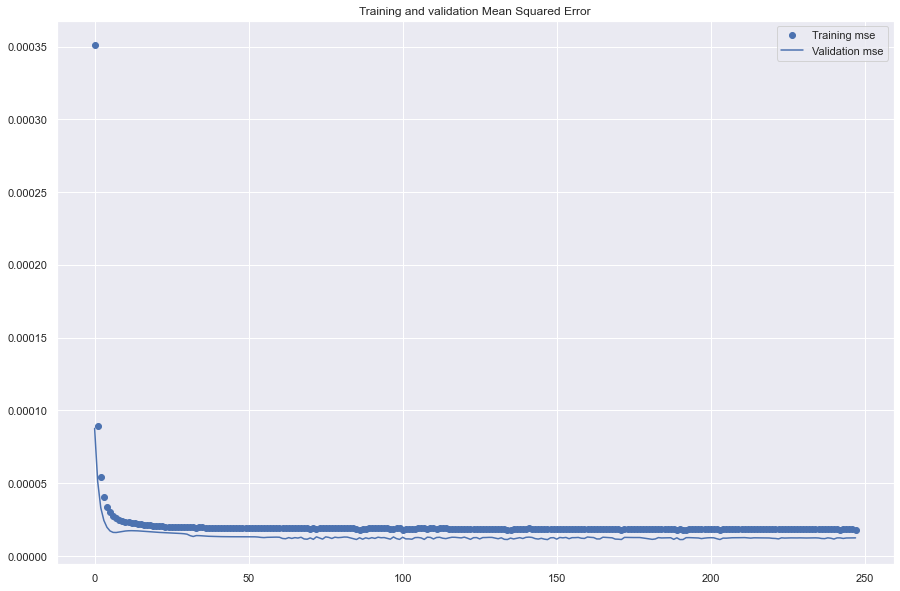

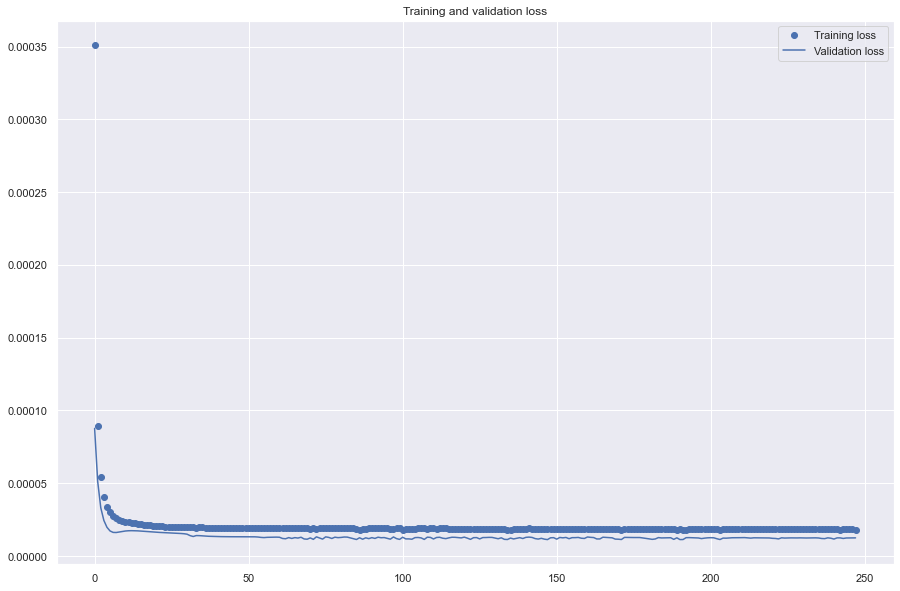

In [ ]:
utils.scatterplotRegression(df=prediction, model_type=model_type, EPOCHS=n_epochs,BATCH_SIZE=BATCH_SIZE)
utils.error_evaluation(epochs,mse,val_mse,loss,val_loss)